In [47]:
import h5py
import numpy as np
from blutils.fit_2dgaussians import fit_gaussian_to_imgs
from scipy.optimize import curve_fit
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from sklearn.metrics import mean_squared_error
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

In [124]:
path = r'C:/Users/alba.gomez.segalas/Documents/MF3 measurements/2024-03-01 beam monitor'
filename = 'BR2-BR2-BG2-BG2.h5'
# filename = 'AR2-BR2-AR2-BR2-2.h5'
hf = h5py.File(path + '/' + filename, 'r')

### Implementation for general number of maxima ###

In [125]:
def img_around_peak(image, peak, width):
    """Return a subimage around the peak, with a given width."""
    row, col = peak
    img = image[row-width//2:row+width//2, col-width//2:col+width//2]
    return img

def create_cpufit_input(data, num_peaks, coordinates, average, width):
    starts = np.arange(0, data.shape[0], average)
    slices = np.array([slice(start, start + average) for start in starts])

    cpufit_input = np.zeros((len(slices)*num_peaks, width, width), dtype=np.float32)

    for i, s in enumerate(slices):
        image = np.mean(data[s], axis=0)
        for j, peak in enumerate(coordinates):
            cpufit_input[i*num_peaks+j] = img_around_peak(image=image, peak=peak, width=width)

    return cpufit_input

Indices of the highest local maxima: [[150 117]
 [131  99]
 [135 136]
 [115 118]]


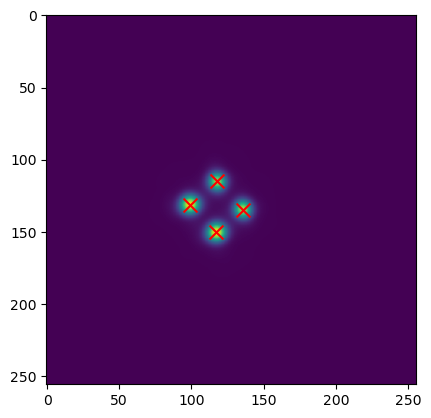

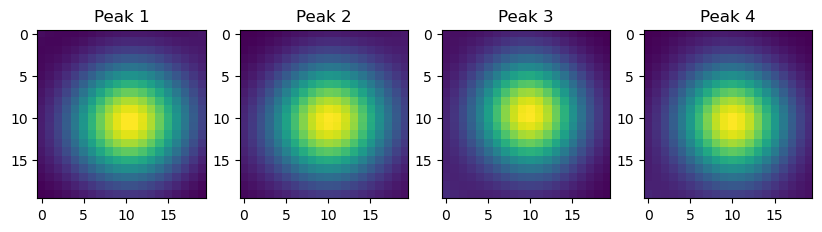

In [126]:
# Select first frame of stack
image = hf['Stacks/movie'][0].astype(np.float32) 
image = ndi.gaussian_filter(image, sigma=3)  

# Define number of peaks in image
num_peaks = 4 

# Find coordinates of peaks
coordinates = peak_local_max(image, min_distance=10, num_peaks=num_peaks)
print("Indices of the highest local maxima:", coordinates)

# def peak_coords(image, num_peaks=4):
#     """Return the coordinates of the highest local maxima in the image."""
#     image = ndi.gaussian_filter(image, sigma=3)  
#     coordinates = peak_local_max(image, min_distance=10, num_peaks=num_peaks)
#     return coordinates

plt.imshow(image)
plt.scatter(coordinates[:, 1], coordinates[:, 0], s=100, c='r', marker='x')

width = 20 # width of squared subimage around the peak

fig, axs = plt.subplots(1,num_peaks,figsize=(10,10))
for i, peak in enumerate(coordinates):
    ax = axs[i]
    ax.imshow(img_around_peak(image, peak, width))
    ax.set_title(f"Peak {i+1}")
plt.show()

In [127]:
hf['Stacks/movie'].shape

(18165, 256, 256)

### Gaussian CPU fit ###

In [128]:
# Convert HDF5 dataset to numpy array
data = hf['Stacks/movie'][...].astype(np.float32) 
average = 2
width = 20

cpufit_input = create_cpufit_input(data, num_peaks=num_peaks, coordinates=coordinates, average=average, width=width)
chunk_size = 100
parameters, chi_sq = fit_gaussian_to_imgs(cpufit_input, chunk_size=chunk_size)

In [129]:
# fit = np.concatenate([parameters, chi_sq[:, None]], axis=1)
# df = pd.DataFrame(fit, columns=['A', 'x', 'y', 'sigma_x', 'sigma_y', 'offset', 'theta', 'chi_sq'])
# df.to_hdf(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'fit data'+f'_avg {average}.h5', key='dataframe_key')

### Fit analysis ###

In [130]:
def two_dimensional_gaussian(x, y, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """
    Compute a two-dimensional Gaussian function.
    
    Parameters:
    - x, y: 1D arrays representing the x and y coordinates
    - amplitude: amplitude of the Gaussian
    - x0, y0: center coordinates of the Gaussian
    - sigma_x, sigma_y: standard deviations in x and y directions
    - offset: amplitude offset
    
    Returns:
    - 2D array representing the computed Gaussian function
    """
    x_term = (x - x0) ** 2 / (2 * sigma_x ** 2)
    y_term = (y - y0) ** 2 / (2 * sigma_y ** 2)
    gaussian = amplitude * np.exp(-(x_term + y_term)) + offset
    return gaussian

def two_dimensional_elliptical_gaussian(x, y, amplitude, x0, y0, sigma_x, sigma_y, offset, angle):
    """
    Compute a two-dimensional elliptical Gaussian function.
    
    Parameters:
    - x, y: 1D arrays representing the x and y coordinates
    - amplitude: amplitude of the Gaussian
    - x0, y0: center coordinates of the Gaussian
    - sigma_x, sigma_y: standard deviations in x and y directions
    - offset: amplitude offset
    - angle: rotation angle in degrees
    
    Returns:
    - 2D array representing the computed elliptical Gaussian function
    """
    angle_rad = angle
    # angle_rad = np.deg2rad(angle)
    x_rot = (x - x0) * np.cos(angle_rad) - (y - y0) * np.sin(angle_rad)
    y_rot = (x - x0) * np.sin(angle_rad) + (y - y0) * np.cos(angle_rad)
    gaussian = amplitude * np.exp(-((x_rot / sigma_x) ** 2 + (y_rot / sigma_y) ** 2) / 2) + offset
    return gaussian
    

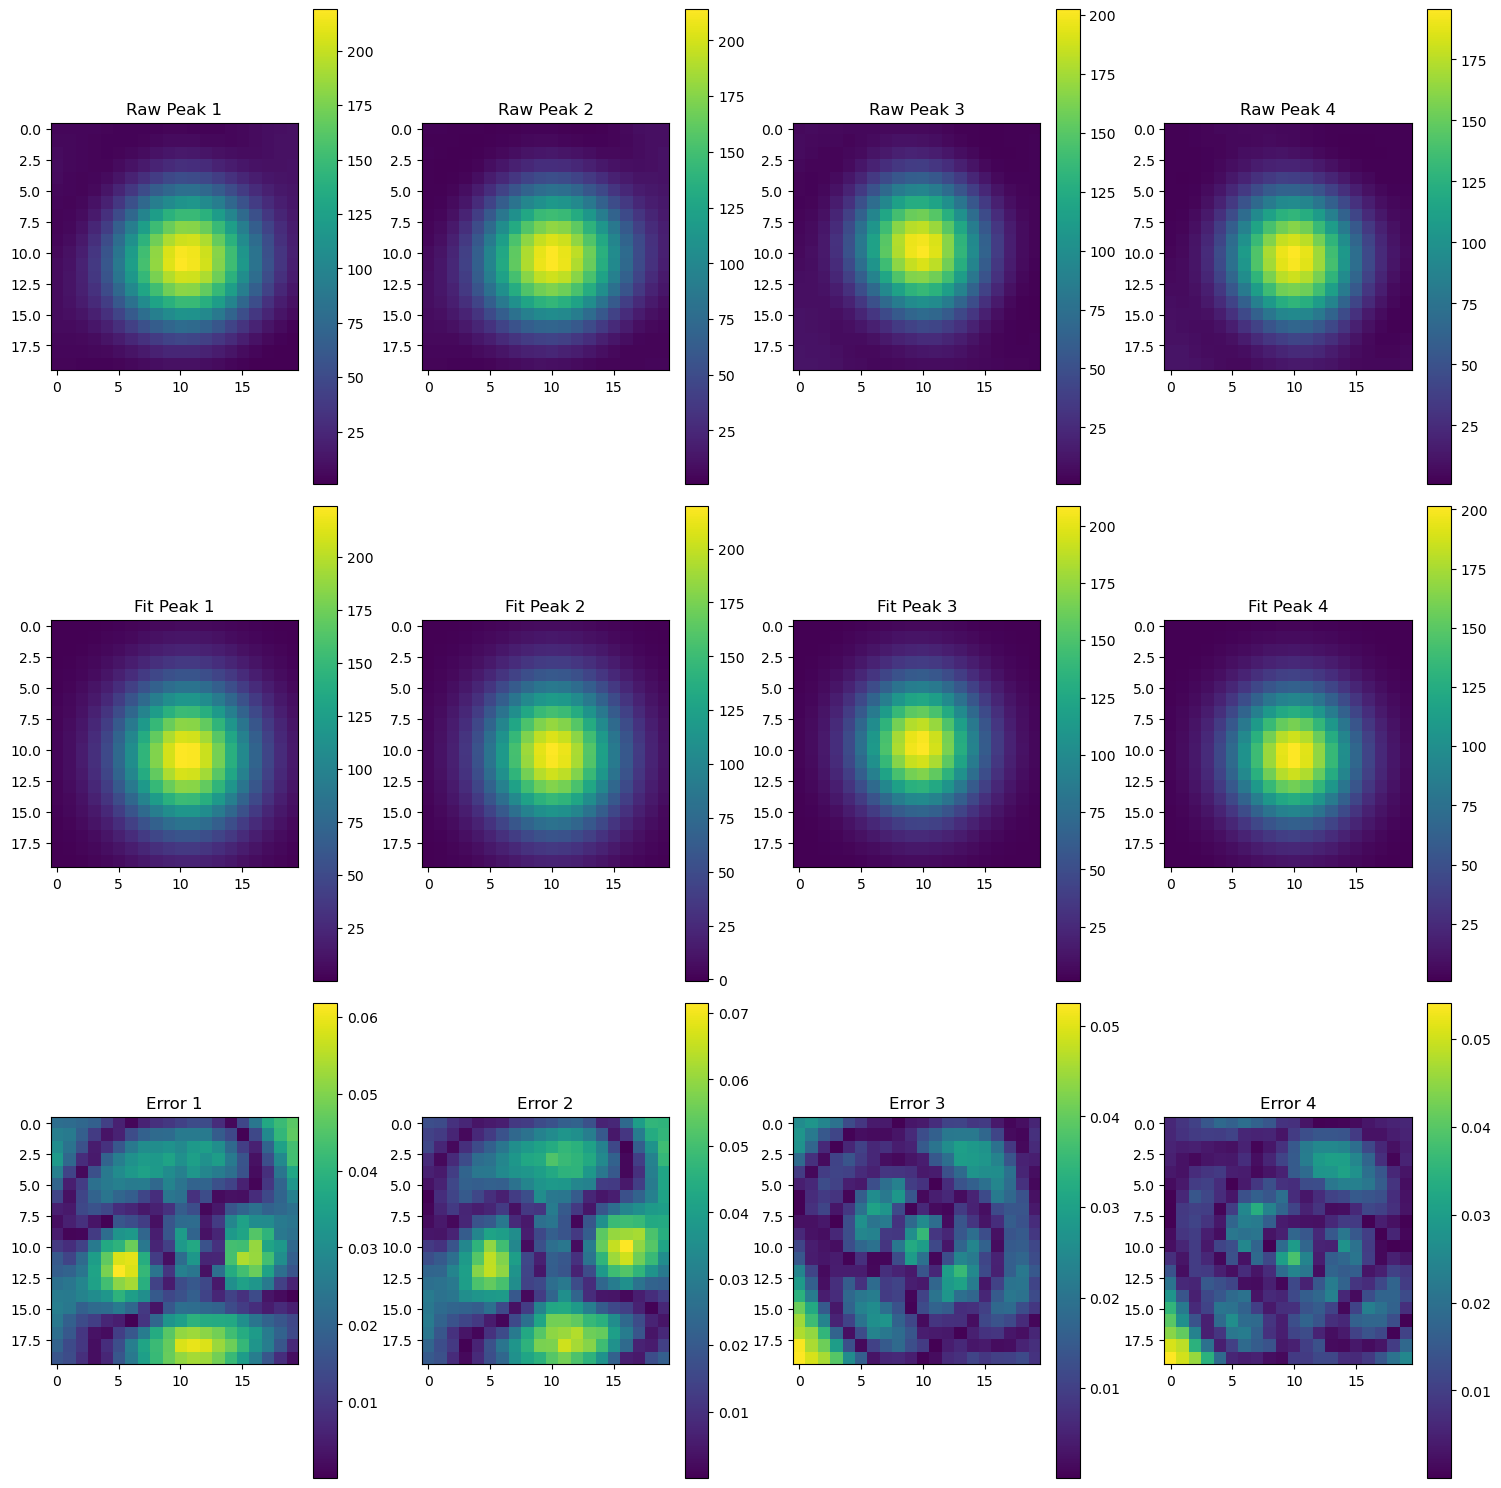

In [131]:
# Choose a random averaged frame set  
gr = data.shape[0]/average
if isinstance(gr, int):
    pass
else:
    gr = int(gr) + 1
random_gr = np.random.choice(range(gr))

X, Y = np.meshgrid(np.arange(width), np.arange(width))


# Plot raw data and 2D Gaussian fit 
fig, axs = plt.subplots(3, num_peaks, figsize=(15, 15))

for i, peak in enumerate(coordinates):
    
    raw_peak = cpufit_input[i + num_peaks * random_gr]
    im0 = axs[0][i].imshow(raw_peak)
    axs[0][i].set_title(f"Raw Peak {i+1}")
    
    fit_peak = two_dimensional_gaussian(X, Y, *parameters[i + num_peaks * random_gr][:6])
    im1 = axs[1][i].imshow(fit_peak)
    axs[1][i].set_title(f"Fit Peak {i+1}")
    
    err = np.abs(raw_peak - fit_peak)/np.max(raw_peak)
    im2 = axs[2][i].imshow(err)
    axs[2][i].set_title(f"Error {i+1}")
    
    fig.colorbar(im0, ax=axs[0][i])
    fig.colorbar(im1, ax=axs[1][i])
    fig.colorbar(im2, ax=axs[2][i])

plt.tight_layout()
plt.show()

# image = raw_peak
# plt.imshow(image)
# max_point = np.unravel_index(np.argmax(image), image.shape)
# plt.plot(max_point[1], max_point[0], 'r+', markersize=10)

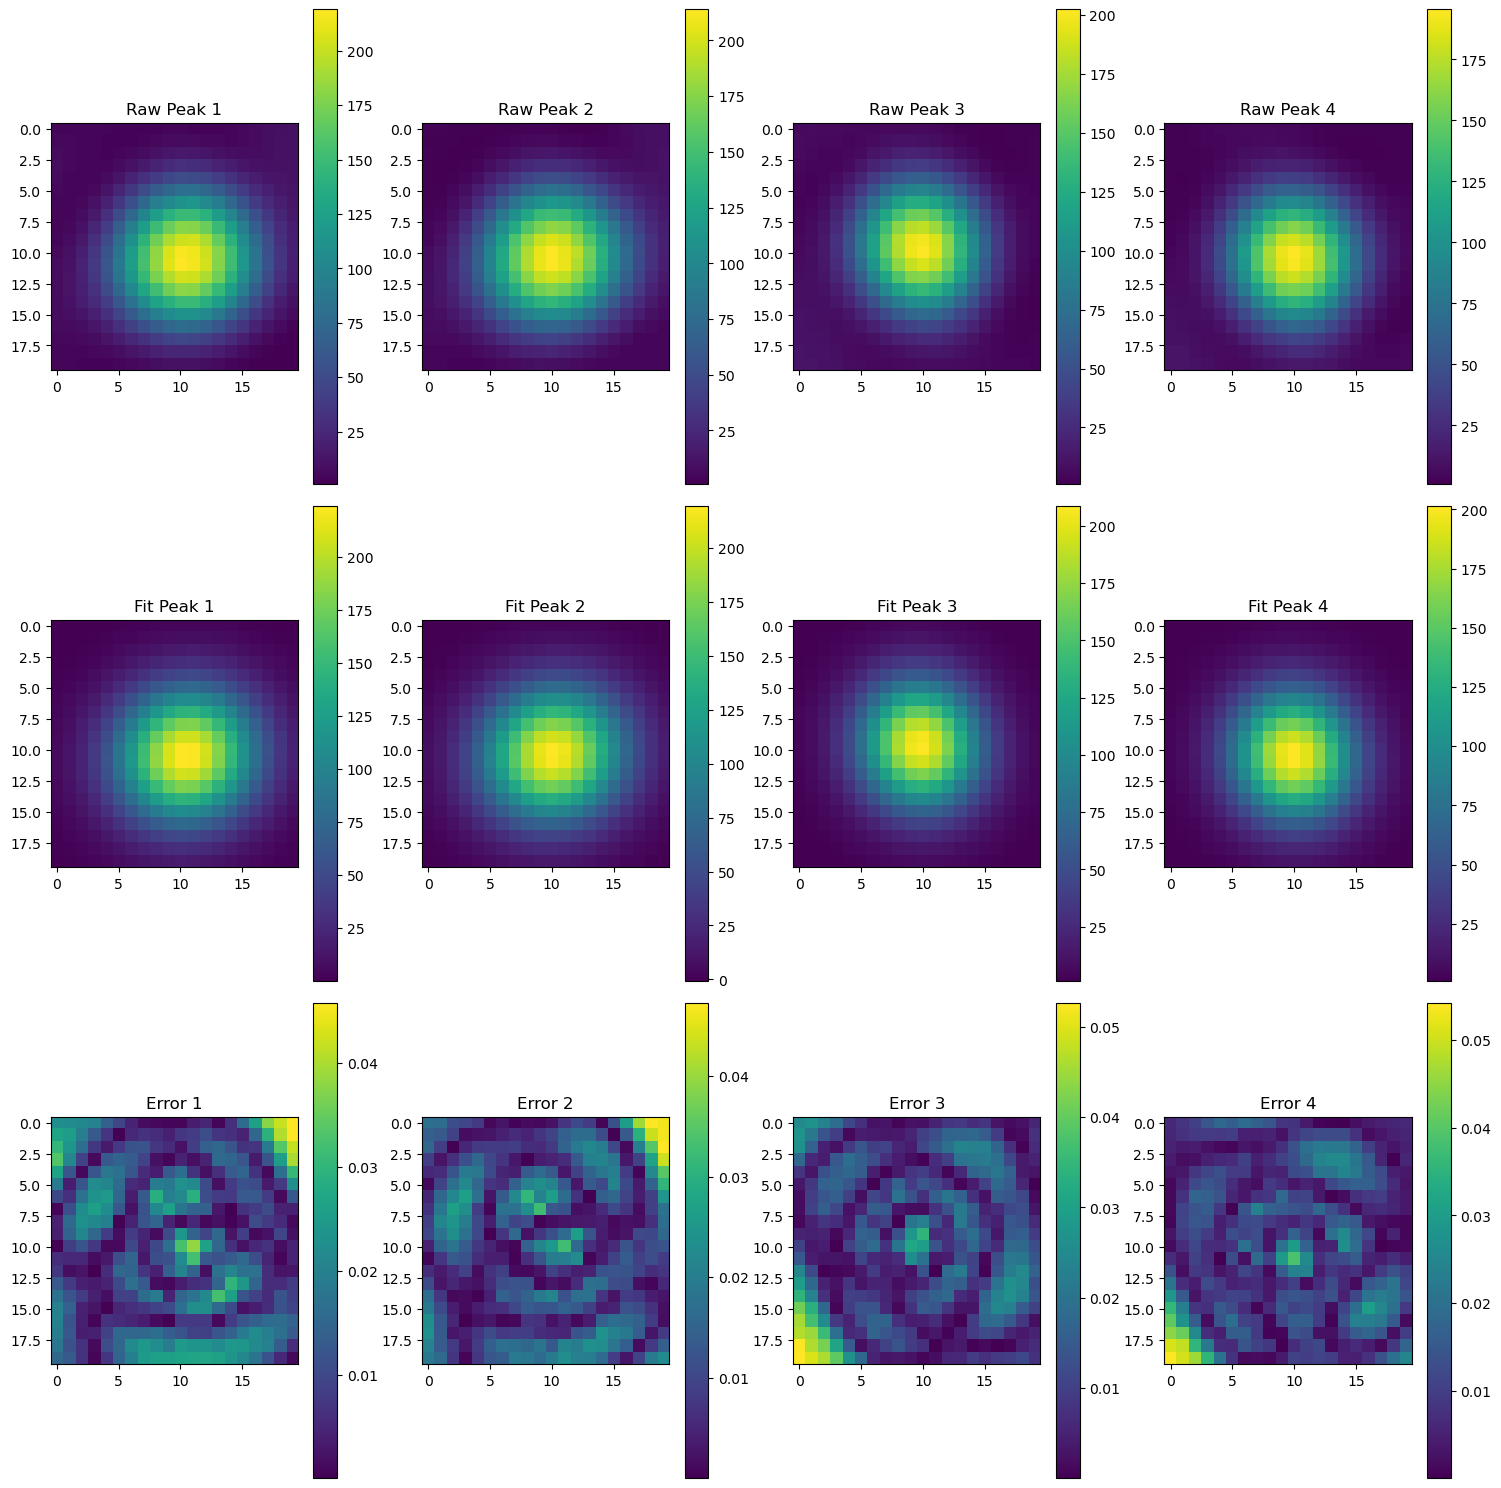

In [132]:
# Plot of raw data and 2D elliptical Gaussian fit
fig, axs = plt.subplots(3, num_peaks, figsize=(15, 15))

for i, peak in enumerate(coordinates):
    
    raw_peak = cpufit_input[i + num_peaks * random_gr]
    im0 = axs[0][i].imshow(raw_peak)
    axs[0][i].set_title(f"Raw Peak {i+1}")
    
    fit_peak = two_dimensional_elliptical_gaussian(X, Y, *parameters[i + num_peaks * random_gr][:7])
    im1 = axs[1][i].imshow(fit_peak)
    axs[1][i].set_title(f"Fit Peak {i+1}")
    
    err = np.abs(raw_peak - fit_peak)/np.max(raw_peak)
    im2 = axs[2][i].imshow(err)
    axs[2][i].set_title(f"Error {i+1}")
    
    fig.colorbar(im0, ax=axs[0][i])
    fig.colorbar(im1, ax=axs[1][i])
    fig.colorbar(im2, ax=axs[2][i])

plt.tight_layout()
plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'2D elliptical Gaussian fit_'+f'avr {average}'+'.png')
plt.show()


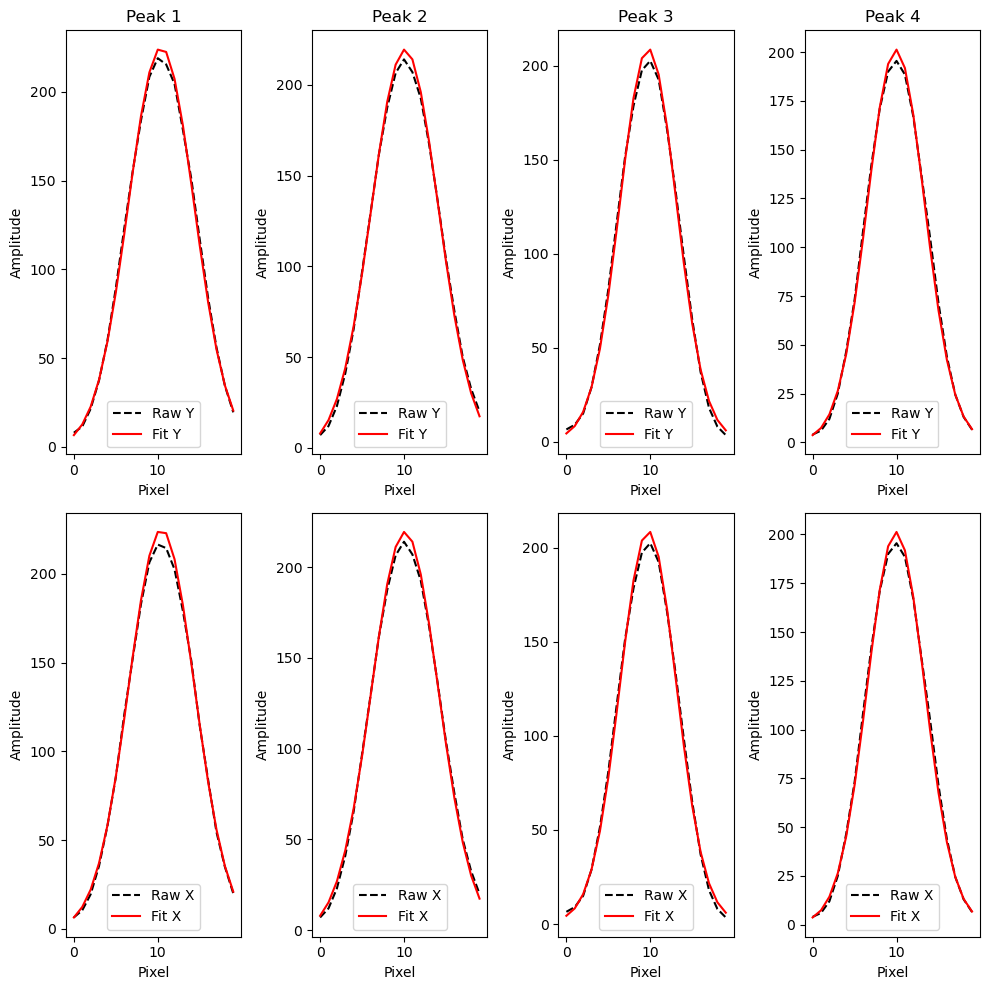

In [133]:
# 1D plots
fig, axs = plt.subplots(2, num_peaks, figsize=(10, 10))

for i, peak in enumerate(coordinates):
    
    fit = two_dimensional_elliptical_gaussian(X, Y, *parameters[i + num_peaks * random_gr][:7])
    
    raw_peak = cpufit_input[i + num_peaks * random_gr]
    peak_subim_coord = np.unravel_index(np.argmax(raw_peak), raw_peak.shape)
    
    axs[0][i].plot(raw_peak[peak_subim_coord[0]], 'k', linestyle='dashed', label='Raw Y')
    axs[0][i].plot(fit[peak_subim_coord[0]], 'r', label='Fit Y')
    axs[0][i].set_xlabel('Pixel')
    axs[0][i].set_ylabel('Amplitude')
    axs[0][i].legend()
    axs[0][i].set_title(f"Peak {i+1}")

    axs[1][i].plot(raw_peak[peak_subim_coord[1]], 'k', linestyle='dashed', label='Raw X')
    axs[1][i].plot(fit[peak_subim_coord[1]],'r', label='Fit X')
    axs[1][i].set_xlabel('Pixel')
    axs[1][i].set_ylabel('Amplitude')
    axs[1][i].legend()

plt.tight_layout()
plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'1D elliptical Gaussian fits_'+f'avr {average}'+'.png')
plt.show()

### Drift analysis ###

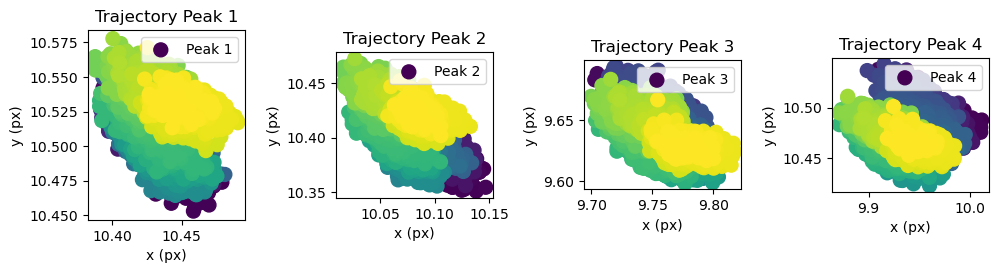

In [134]:
fig, axs = plt.subplots(1, num_peaks, figsize=(10, 5))
for i, peak in enumerate(coordinates):
    x = parameters[slice(i,None,num_peaks)][:,1] 
    y = parameters[slice(i,None,num_peaks)][:,2] 
    # x = parameters[slice(i,None,num_peaks)][:,1] + peak[1] - width//2
    # y = parameters[slice(i,None,num_peaks)][:,2] + peak[0] - width//2  
    color = np.arange(len(x))  
    axs[i].scatter(x, y, c=color, s=100, label=f'Peak {i+1}')
    # axs[i].plot(x, y, 'k', linestyle='solid')
    axs[i].set_aspect('equal')  
    axs[i].set_xlabel('x (px)')
    axs[i].set_ylabel('y (px)')
    axs[i].set_title(f"Trajectory Peak {i+1}")
    axs[i].legend()
plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'XY trajectories_'+f'avr {average}'+'.png')
plt.tight_layout()
plt.show()

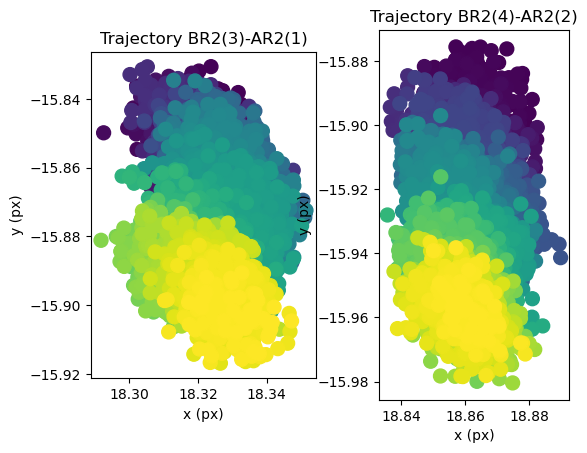

In [135]:
fig, axs = plt.subplots(1, 2)

i, j = 2, 0 
x = parameters[slice(i,None,num_peaks)][:,1] + coordinates[i][1] - width//2 - (parameters[slice(j,None,num_peaks)][:,1] + coordinates[j][1] - width//2)
y = parameters[slice(i,None,num_peaks)][:,2] + coordinates[i][0] - width//2 - (parameters[slice(j,None,num_peaks)][:,2] + coordinates[j][0] - width//2)
color = np.arange(len(x))  
axs[0].scatter(x, y, c=color, s=100, label=f'Peak {i+1}')
axs[0].set_aspect('equal')  
axs[0].set_xlabel('x (px)')
axs[0].set_ylabel('y (px)')
axs[0].set_title(f"Trajectory BR2({i+1})-AR2({j+1})")
i, j = 3, 1
x = parameters[slice(i,None,num_peaks)][:,1] + coordinates[i][1] - width//2 - (parameters[slice(j,None,num_peaks)][:,1] + coordinates[j][1] - width//2)
y = parameters[slice(i,None,num_peaks)][:,2] + coordinates[i][0] - width//2 - (parameters[slice(j,None,num_peaks)][:,2] + coordinates[j][0] - width//2)   
color = np.arange(len(x))  
axs[1].scatter(x, y, c=color, s=100, label=f'Peak {i+1}')
axs[1].set_aspect('equal')  
axs[1].set_xlabel('x (px)')
axs[1].set_ylabel('y (px)')
axs[1].set_title(f"Trajectory BR2({i+1})-AR2({j+1})")
plt.show()

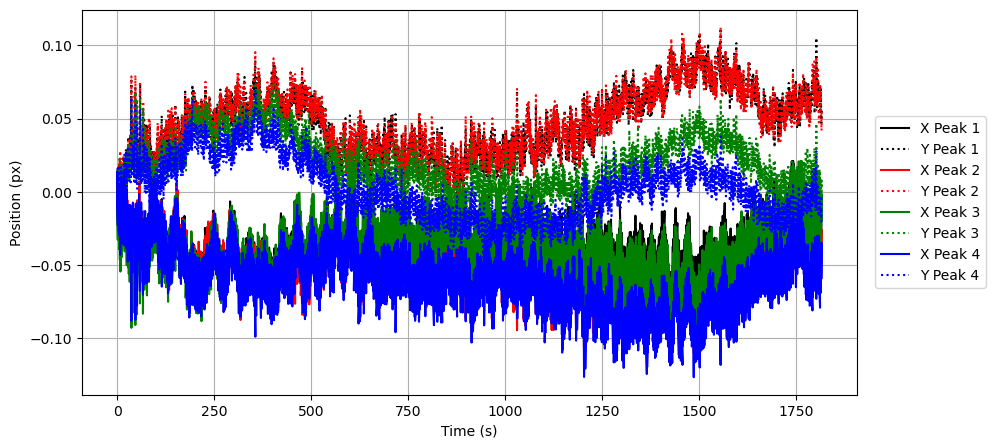

In [136]:
framerate = 10 # Hz
t = np.arange(0, data.shape[0], average)*(1/framerate)
c = ['k', 'r', 'g', 'b']

plt.figure(figsize=(10, 5))
for i, peak in enumerate(coordinates):
    # x = parameters[slice(i,None,num_peaks)][:,1] + peak[1] - width//2
    # y = parameters[slice(i,None,num_peaks)][:,2] + peak[0] - width//2
    x = parameters[slice(i,None,num_peaks)][:,1] 
    y = parameters[slice(i,None,num_peaks)][:,2] 
    plt.plot(t, x-x[0], color=c[i], linestyle='solid', label=f'X Peak {i+1}')
    plt.plot(t, y-y[0], color=c[i], linestyle='dotted', label=f'Y Peak {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Position (px)')
plt.legend(loc='center right', bbox_to_anchor=(1.175, 0.5))
# plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'XY traces_'+f'avr {average}'+'.png')
plt.grid()
plt.show()

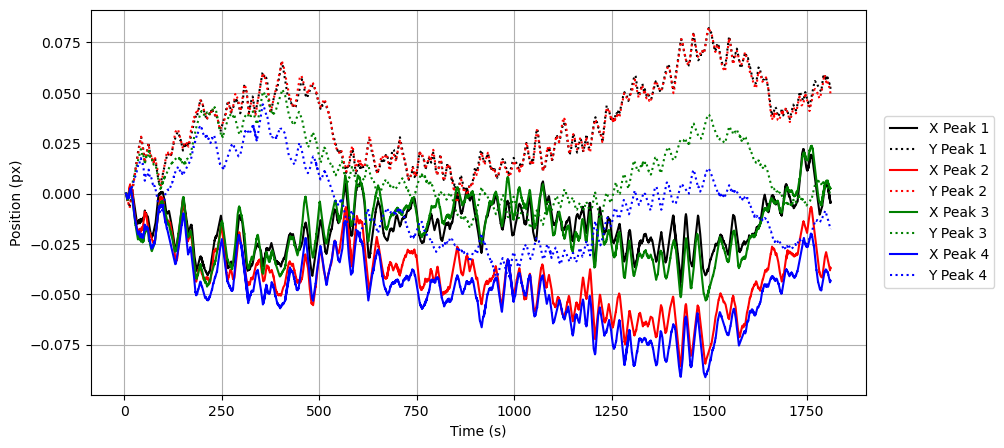

In [137]:
window = 50

t_avr = sliding_window_view(t, window_shape=window).mean(axis=1)

plt.figure(figsize=(10, 5))
for i, peak in enumerate(coordinates):
    # x = parameters[slice(i,None,num_peaks)][:,1] + peak[1] - width//2
    # y = parameters[slice(i,None,num_peaks)][:,2] + peak[0] - width//2
    x = parameters[slice(i,None,num_peaks)][:,1]
    x_avr = sliding_window_view(x, window_shape=window).mean(axis=1) 
    y = parameters[slice(i,None,num_peaks)][:,2] 
    y_avr = sliding_window_view(y, window_shape=window).mean(axis=1)
    plt.plot(t_avr, x_avr-x_avr[0], color=c[i], linestyle='solid', label=f'X Peak {i+1}')
    plt.plot(t_avr, y_avr-y_avr[0], color=c[i], linestyle='dotted', label=f'Y Peak {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Position (px)')
plt.legend(loc='center right', bbox_to_anchor=(1.175, 0.5))
# plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'XY traces_'+f'avr {average}'+f'rolling avr {window}'+'.png')
plt.grid()
plt.show()

In [138]:
# Distance between peaks
print('Distance between peaks 1 and 2 (px):', round(np.sqrt((coordinates[0][0]-coordinates[1][0])**2 + (coordinates[0][1]-coordinates[1][1])**2), 2))
print('Distance between peaks 1 and 3 (px):', round(np.sqrt((coordinates[0][0]-coordinates[2][0])**2 + (coordinates[0][1]-coordinates[2][1])**2), 2))
print('Distance between peaks 1 and 4 (px):', round(np.sqrt((coordinates[0][0]-coordinates[3][0])**2 + (coordinates[0][1]-coordinates[3][1])**2), 2))
print('Distance between peaks 2 and 3 (px):', round(np.sqrt((coordinates[1][0]-coordinates[2][0])**2 + (coordinates[1][1]-coordinates[2][1])**2), 2))
print('Distance between peaks 2 and 4 (px):', round(np.sqrt((coordinates[1][0]-coordinates[3][0])**2 + (coordinates[1][1]-coordinates[3][1])**2), 2))
print('Distance between peaks 3 and 4 (px):', round(np.sqrt((coordinates[2][0]-coordinates[3][0])**2 + (coordinates[2][1]-coordinates[3][1])**2), 2))


Distance between peaks 1 and 2 (px): 26.17
Distance between peaks 1 and 3 (px): 24.21
Distance between peaks 1 and 4 (px): 35.01
Distance between peaks 2 and 3 (px): 37.22
Distance between peaks 2 and 4 (px): 24.84
Distance between peaks 3 and 4 (px): 26.91


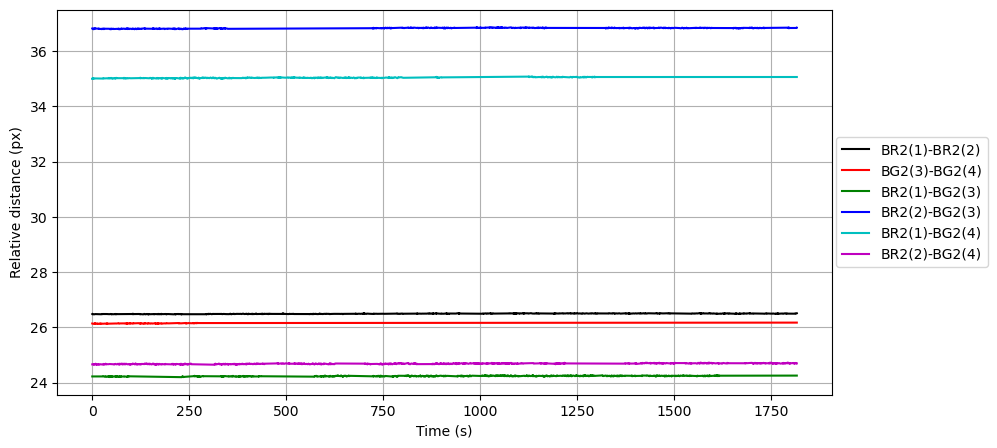

In [144]:
# Relative distance 
def relative_distance(parameters, coordinates, peak1, peak2, mean=True):
    x1 = parameters[slice(peak1,None,num_peaks)][:,1] + coordinates[peak1][1] - width//2
    y1 = parameters[slice(peak1,None,num_peaks)][:,2] + coordinates[peak1][0] - width//2
    x2 = parameters[slice(peak2,None,num_peaks)][:,1] + coordinates[peak2][1] - width//2
    y2 = parameters[slice(peak2,None,num_peaks)][:,2] + coordinates[peak2][0] - width//2
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    if mean:
        m = np.mean(dist)
    else:
        m = 0
    return dist-m

color = ['k', 'r', 'g', 'b', 'c', 'm']
mean = False

plt.figure(figsize=(10, 5))
y = relative_distance(parameters, coordinates, 0, 1, mean=mean)    
# plt.plot(t, y-y[0], color=color[0], linestyle='solid', label='BR2(1)-BR2(2)')
plt.plot(t, y, color=color[0], linestyle='solid', label='BR2(1)-BR2(2)')
y = relative_distance(parameters, coordinates, 2, 3, mean=mean)  
# plt.plot(t, y-y[0], color=color[1], linestyle='solid', label='BG2(3)-BG2(4)')
plt.plot(t, y, color=color[1], linestyle='solid', label='BG2(3)-BG2(4)')
y = relative_distance(parameters, coordinates, 0, 2, mean=mean)  
# plt.plot(t, y-y[0], color=color[2], linestyle='solid', label='BR2(1)-BG2(3)')
plt.plot(t, y, color=color[2], linestyle='solid', label='BR2(1)-BG2(3)')
y = relative_distance(parameters, coordinates, 1, 2, mean=mean)  
# plt.plot(t, y-y[0], color=color[3], linestyle='solid', label='BR2(2)-BG2(3)')
plt.plot(t, y, color=color[3], linestyle='solid', label='BR2(2)-BG2(3)')
y = relative_distance(parameters, coordinates, 0, 3, mean=mean)  
# plt.plot(t, y-y[0], color=color[4], linestyle='solid', label='BR2(1)-BG2(4)')
plt.plot(t, y, color=color[4], linestyle='solid', label='BR2(1)-BG2(4)')
y = relative_distance(parameters, coordinates, 1, 3, mean=mean)  
# plt.plot(t, y-y[0], color=color[5], linestyle='solid', label='BR2(2)-BG2(4)')
plt.plot(t, y, color=color[5], linestyle='solid', label='BR2(2)-BG2(4)')
plt.xlabel('Time (s)')
plt.ylabel('Relative distance (px)')
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.grid()
# plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'rel distance_'+f'avr {average}'+'.png')
plt.show()

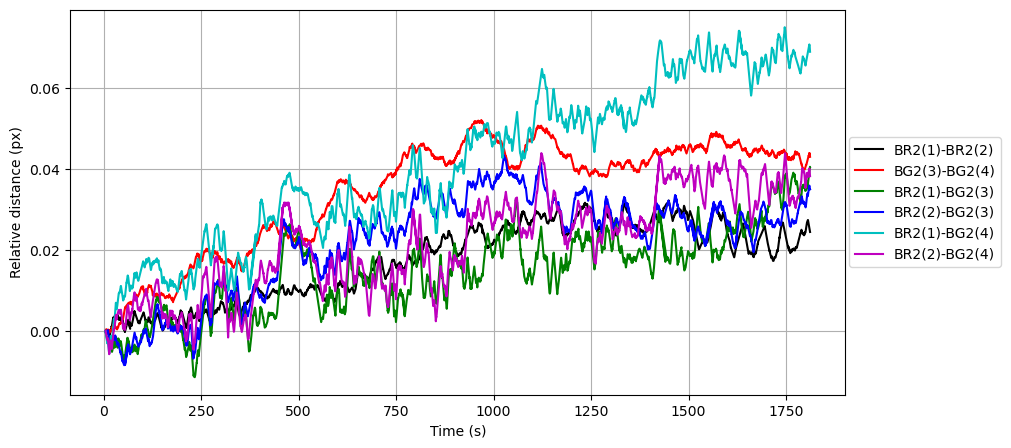

In [140]:
window = 50

t_avr = sliding_window_view(t, window_shape = window).mean(axis=1)

plt.figure(figsize=(10, 5))
y = relative_distance(parameters, coordinates, 0, 1, mean=mean)
y_avr = sliding_window_view(y, window_shape = window).mean(axis=1)    
plt.plot(t_avr, y_avr-y_avr[0], color=color[0], linestyle='solid', label='BR2(1)-BR2(2)')
y = relative_distance(parameters, coordinates, 2, 3, mean=mean)
y_avr = sliding_window_view(y, window_shape = window).mean(axis=1)    
plt.plot(t_avr, y_avr-y_avr[0], color=color[1], linestyle='solid', label='BG2(3)-BG2(4)')
y = relative_distance(parameters, coordinates, 0, 2, mean=mean)  
y_avr = sliding_window_view(y, window_shape = window).mean(axis=1)  
plt.plot(t_avr, y_avr-y_avr[0], color=color[2], linestyle='solid', label='BR2(1)-BG2(3)')
y = relative_distance(parameters, coordinates, 1, 2, mean=mean)  
y_avr = sliding_window_view(y, window_shape = window).mean(axis=1)  
plt.plot(t_avr, y_avr-y_avr[0], color=color[3], linestyle='solid', label='BR2(2)-BG2(3)')
y = relative_distance(parameters, coordinates, 0, 3, mean=mean)  
y_avr = sliding_window_view(y, window_shape = window).mean(axis=1)  
plt.plot(t_avr, y_avr-y_avr[0], color=color[4], linestyle='solid', label='BR2(1)-BG2(4)')
y = relative_distance(parameters, coordinates, 1, 3, mean=mean)  
y_avr = sliding_window_view(y, window_shape = window).mean(axis=1)  
plt.plot(t_avr, y_avr-y_avr[0], color=color[5], linestyle='solid', label='BR2(2)-BG2(4)')
plt.xlabel('Time (s)')
plt.ylabel('Relative distance (px)')
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.grid()
# plt.savefig(path+'/'+'analysis'+'/'+filename.split('.')[0]+'/'+'rel distance_'+f'avr {average}_'+f'rolling avr {window}'+'.png')
plt.show()

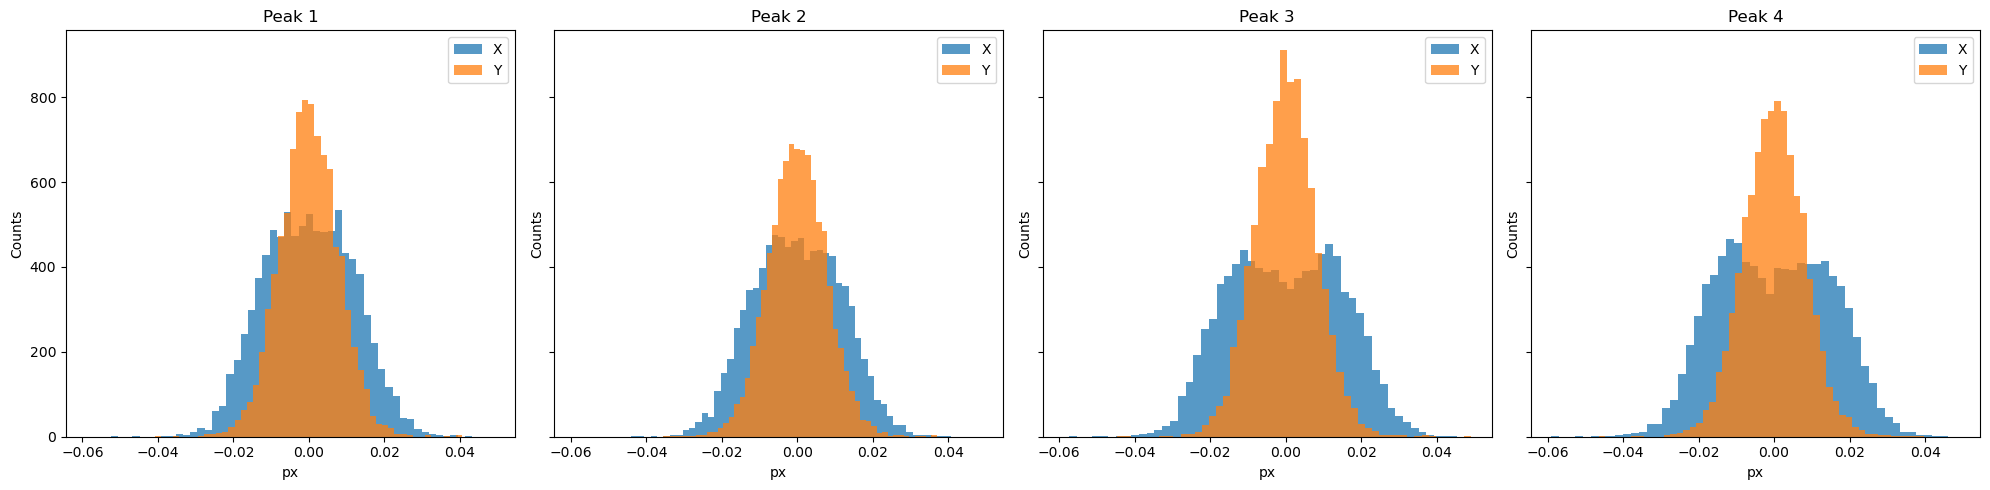

In [141]:
fig, axs = plt.subplots(1, num_peaks, figsize=(20, 5), sharey=True, sharex=True)

for i, peak in enumerate(coordinates):
    axs[i].hist(np.diff(parameters[slice(i,None,num_peaks)][:,1]), bins=50, alpha=0.75, label='X')
    axs[i].hist(np.diff(parameters[slice(i,None,num_peaks)][:,2]), bins=50, alpha=0.75, label='Y')
    axs[i].set_xlabel('px')
    axs[i].set_ylabel('Counts')
    axs[i].set_title(f"Peak {i+1}")
    axs[i].legend()

plt.tight_layout()
plt.show()

In [142]:
parameters[slice(i,None,num_peaks)][:,1].shape

(9083,)

### Test subparts of CPU fitting code 

In [143]:
nfit = 120
chunk_size = 50
np.linspace(0,nfit,np.ceil(nfit/chunk_size).astype(int)+1)

array([  0.,  40.,  80., 120.])